In [27]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('Set2')

<Figure size 1000x3000 with 0 Axes>

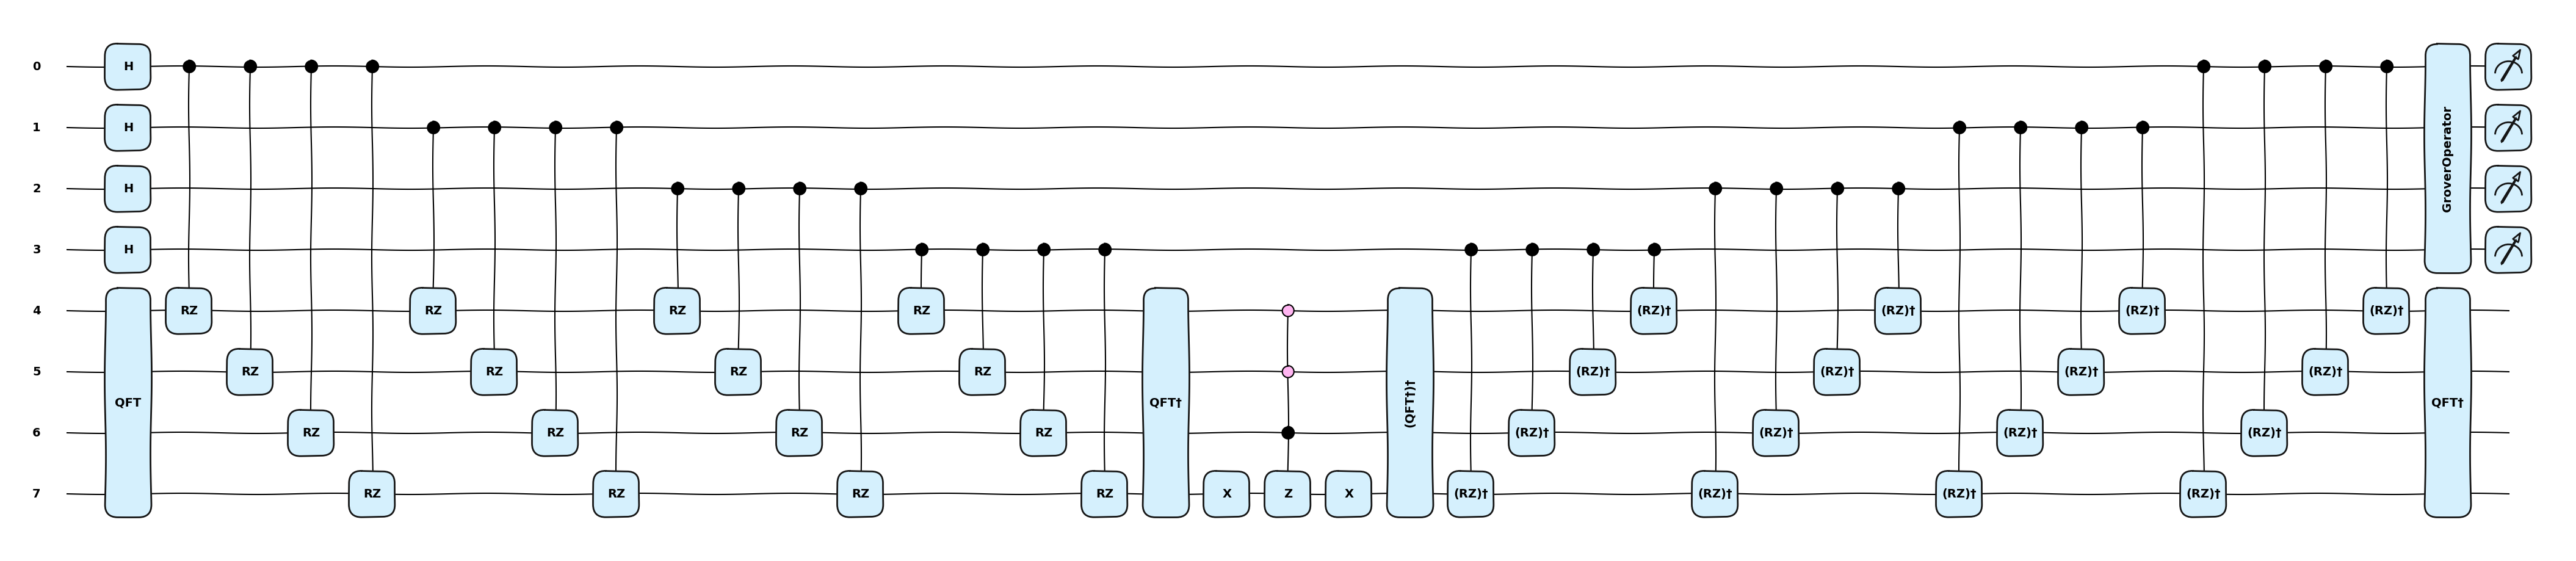

In [28]:
def oracle(numbers, goal, wires, aux_wires):
    """Oracle to mark states where the sum of the selected numbers is equal to the goal."""
    
    def add_k_fourier(k, wires):
        for j in range(len(wires)):
            qml.RZ(k * np.pi / (2**j), wires=wires[j])

    def compute_sum_in_fourier_basis():
        qml.QFT(wires=aux_wires)
        for idx, wire in enumerate(wires):
            qml.ctrl(add_k_fourier, control=wire)(numbers[idx], wires=aux_wires)
        qml.adjoint(qml.QFT)(wires=aux_wires)
        
    compute_sum_in_fourier_basis()

    qml.FlipSign(goal, aux_wires) ## check
    
    qml.adjoint(compute_sum_in_fourier_basis)()

def grover_circuit(numbers, goal, rep):
    num_wires = len(numbers)
    aux_wires = [num_wires + i for i in range(num_wires)]
    dev = qml.device("default.qubit", wires=num_wires + num_wires)
    
    @qml.qnode(dev)
    def circuit():
        # Step 1: Apply Hadamard gates to all variable wires
        for wire in range(num_wires):
            qml.Hadamard(wires=wire)
        
        for _ in range(rep):
            # Step 2: Apply the oracle
            oracle(numbers, goal, range(num_wires), aux_wires)
            
            # Step 3: Apply Grover's diffusion operator
            qml.GroverOperator(wires=range(num_wires))
        
        return qml.probs(wires=range(num_wires))
    
    return circuit

numbers = [1,1,1,2] 
goal = 2  # goal sum
rep = 1 # number of Grover iterations

# Get the circuit function
circuit = grover_circuit(numbers, goal, rep)

# Extract probabilities
result = circuit()

# Draw the circuit with all wires
plt.figure(figsize=(10, 30))
qml.draw_mpl(circuit, 
             show_all_wires=True, 
             style="pennylane_sketch",
             expansion_strategy="device")()
plt.show()


<BarContainer object of 16 artists>

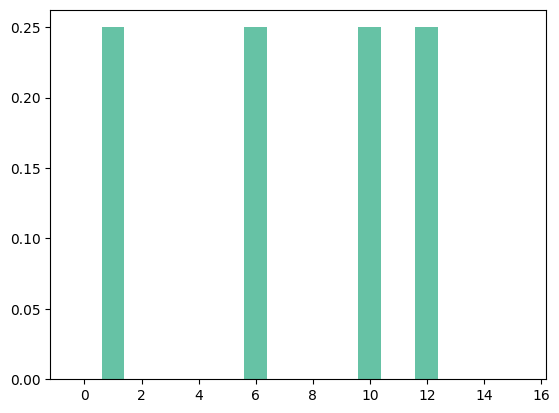

In [29]:
plt.bar( range(len(result)),  result)

In [19]:
maxiter = 20
max_pos = np.argmax(result) ## solution in position
sol_probs = [grover_circuit(numbers, goal, rep=i)()[max_pos] 
             for i in range (0,maxiter)]

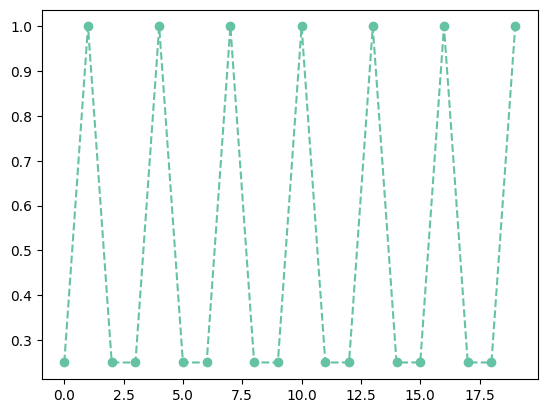

In [20]:
import seaborn as sns
## treshold to check if 2 numbers are equal
treshold = 10e-5
num_of_sol = np.sum(np.abs(result.numpy() - np.max(result).numpy()) < treshold) 

plt.plot(range(0,maxiter), (np.array(sol_probs) * num_of_sol), marker='o', linestyle='--', label='solution probability')

In [25]:
sol_probs == (np.max(sol_probs))

array([False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [32]:
np.sum(result.numpy() == np.max(result.numpy()))

1

tensor(4, requires_grad=True)

In [39]:
result.numpy()

array([4.56110531e-31, 2.50000000e-01, 3.25344378e-31, 2.03945776e-31,
       3.25344378e-31, 2.03945776e-31, 2.50000000e-01, 2.72494477e-31,
       3.25344378e-31, 2.04330962e-31, 2.50000000e-01, 2.75961151e-31,
       2.50000000e-01, 2.75961151e-31, 1.72102930e-31, 3.52922092e-31])